In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import pydot

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from IPython.display import Image
from sklearn.externals.six import StringIO

In [3]:
#import datasets, define full dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
full_df = [train_df, test_df]

#storing passgenger ids in case we need them later
train_pass_id = train_df['PassengerId']
test_pass_id = test_df['PassengerId']

In [4]:
#take a look at training set
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
train_df.mean()

PassengerId    446.000000
Survived         0.383838
Pclass           2.308642
Age             29.699118
SibSp            0.523008
Parch            0.381594
Fare            32.204208
dtype: float64

In [7]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
#take a look at testing set
test_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
test_df.mean()

PassengerId    1100.500000
Pclass            2.265550
Age              30.272590
SibSp             0.447368
Parch             0.392344
Fare             35.627188
dtype: float64

In [10]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [11]:
#feature_engineering and examining features on its own

#Pclass
print (train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [12]:
#gender
print (train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [13]:
#gender - con'd transform data into 0s and 1s
for dataset in full_df:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

/Users/raehuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


  CategoricalAge  Survived
0  (-0.08, 16.0]  0.508929
1   (16.0, 32.0]  0.363229
2   (32.0, 48.0]  0.363636
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


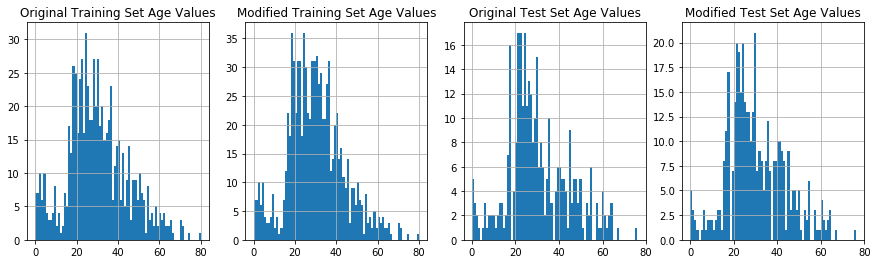

In [14]:
#age has a lot of missing values, about 20% for the training set

#we want to plot differences in training/testing set original v.s. modified
#age distribution - modified is after we remove missing values in following steps
fig, (axis1,axis2,axis3,axis4) = plt.subplots(1,4,figsize=(15,4))
axis1.set_title('Original Training Set Age Values')
axis2.set_title('Modified Training Set Age Values')
axis3.set_title('Original Test Set Age Values')
axis4.set_title('Modified Test Set Age Values')

org_train = train_df['Age'].dropna().astype(int).hist(bins=80, ax=axis1)
org_test = test_df['Age'].dropna().astype(int).hist(bins=80, ax=axis3)

#remove missing values by filling in a random integer
for dataset in full_df:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train_df['CategoricalAge'] = pd.cut(train_df['Age'], 5)
print (train_df[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

mod_train = train_df['Age'].hist(bins=80, ax=axis2)
mod_test = test_df['Age'].hist(bins=80, ax=axis4)

In [15]:
for dataset in full_df:    
    dataset.loc[dataset['Age'] <= 16, 'Cat_Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Cat_Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Cat_Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Cat_Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Cat_Age'] = 4;
    dataset['Cat_Age'] = dataset['Cat_Age'].astype(int)

In [16]:
#Create familysize feature as a calcultion from siblings + parents
for dataset in full_df:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] +1
print (train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [17]:
#Embarked has 2 missing values - populate with 'S' as it's the most popular departure port
for dataset in full_df:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
print (train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

   Embarked  Survived
0         0  0.339009
1         1  0.553571
2         2  0.389610


In [18]:
#Fare has a missing value in the test set - will fill with average fare of training set
for dataset in full_df:
    dataset['Fare'] = dataset['Fare'].fillna('32.2042')
    dataset['Fare'] = dataset['Fare'].astype(float)

In [19]:
#take a look at the current features included
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CategoricalAge,Cat_Age,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NaN,0,"(16.0, 32.0]",1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,1,"(32.0, 48.0]",2,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NaN,0,"(16.0, 32.0]",1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,0,"(32.0, 48.0]",2,2
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,NaN,0,"(32.0, 48.0]",2,1


In [20]:
#take another look at the datatypes of the dataset
train_df.dtypes

PassengerId          int64
Survived             int64
Pclass               int64
Name                object
Sex                  int64
Age                  int64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked             int64
CategoricalAge    category
Cat_Age              int64
FamilySize           int64
dtype: object

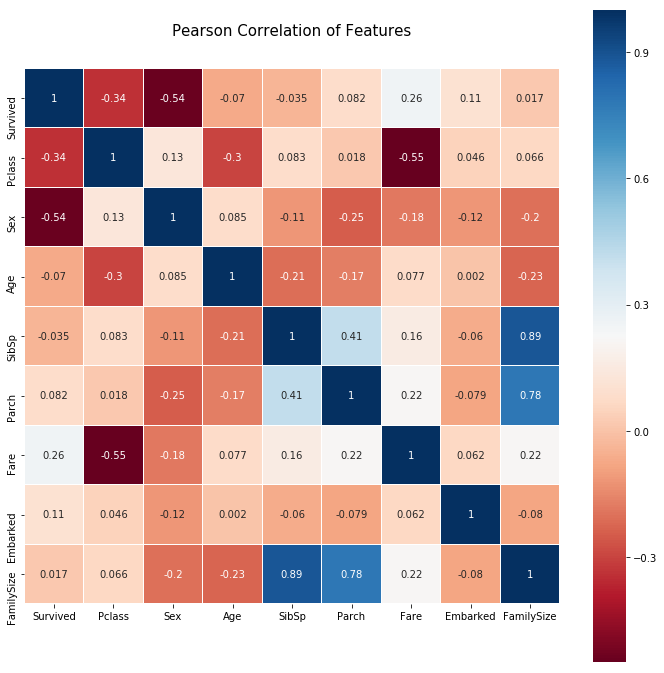

In [21]:
train_df_corr = train_df.drop(['PassengerId','CategoricalAge','Name','Ticket','Cabin','Cat_Age'], axis=1)

colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df_corr.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, 
            linecolor='white', annot=True)

In [22]:
train_df.dtypes

PassengerId          int64
Survived             int64
Pclass               int64
Name                object
Sex                  int64
Age                  int64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked             int64
CategoricalAge    category
Cat_Age              int64
FamilySize           int64
dtype: object

In [23]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CategoricalAge,Cat_Age,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NaN,0,"(16.0, 32.0]",1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,1,"(32.0, 48.0]",2,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NaN,0,"(16.0, 32.0]",1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,0,"(32.0, 48.0]",2,2
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,NaN,0,"(32.0, 48.0]",2,1


In [24]:
#dropping SibSp and Parch as they are used directly in calculation of FamilySize
train_df_model = train_df.drop(['PassengerId','CategoricalAge','Name','Ticket','Cabin','SibSp','Parch'], axis=1)
test_df_model = test_df.drop(['PassengerId','Name','Ticket','Cabin','SibSp','Parch'], axis = 1)

In [25]:
train_df_model.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Cat_Age,FamilySize
0,0,3,1,22,7.2500,0,1,2
1,1,1,0,38,71.2833,1,2,2
2,1,3,0,26,7.9250,0,1,1
3,1,1,0,35,53.1000,0,2,2
4,0,3,1,35,8.0500,0,2,1


In [26]:
test_df_model.head(5)

,Pclass,Sex,Age,Fare,Embarked,Cat_Age,FamilySize
0,3,1,34,7.8292,2,2,1
1,3,0,47,7.0000,0,2,2
2,2,1,62,9.6875,2,3,1
3,3,1,27,8.6625,0,1,1
4,3,0,22,12.2875,0,1,3


In [27]:
#checking to see there are no missing values in training and testing sets
train_df_model.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Cat_Age       0
FamilySize    0
dtype: int64

In [28]:
test_df_model.isnull().sum()

Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Cat_Age       0
FamilySize    0
dtype: int64

In [29]:
#decision tree model - find number of nodes to use
#desired cross-validation nodes = 10
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(test_df_model))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    
    for train_fold, valid_fold in cv.split(train_df_model):
        f_train = train_df_model.loc[train_fold] # Extract training set with cv indices
        f_valid = train_df_model.loc[valid_fold] # Extract validation set with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train set
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation set
        fold_accuracy.append(valid_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy) #calculation of average accuracy
    accuracies.append(avg)
    
#show avergae accuracy rates for each tree depth
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

Max Depth  Average Accuracy
        1          0.786729
        2          0.766654
        3          0.814831
        4          0.800337
        5          0.813758
        6          0.800287
        7          0.807029


In [30]:
#the best number of features seem to be 3, since more would be overfitting

#decision tree model - final model

#Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train_df_model['Survived']
x_train = train_df_model.drop(['Survived'], axis=1).values 
x_test = test_df_model.values

x_train_df = train_df_model.drop(['Survived'], axis=1)

#Create tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3, random_state=1007)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1007,
            splitter='best')

In [31]:
#Prediction of results for test set
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": test_pass_id,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

In [32]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.719999999999999

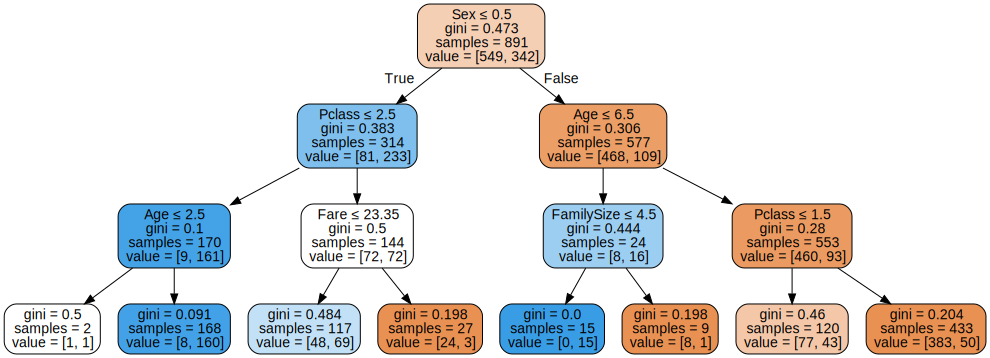

In [36]:
#other method of tree visualization
import graphviz 
dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                         feature_names = x_train_df.columns,   
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph  

In [34]:
#other decision_tree visualization method
#with open("dt.txt", "w") as f:
#    f = tree.export_graphviz(decision_tree, feature_names = x_train_df.columns, out_file=f)
#take output file and go to: http://webgraphviz.com/ to visualize

In [35]:
#Notes - other method for visualization - check up on later
#df = pd.read_clipboard()
#X = tdf[df.columns[:-1]]
#y = df[df.columns[-1]]

#dot_data = StringIO()  
#tree.export_graphviz(decision_tree, out_file=dot_data, feature_names=X.columns)  
#graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png()) 